## ステップ43： ニューラルネットワーク

In [1]:
# if '__file__' in globals():
#     import os, sys
#     sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

線形回帰（step42）の実装は（損失関数を除くと）「行列の積」と「足し算」のみ  
　　→線形変換(linear transformation)またはアフィン変換(affine transformation)と呼ばれる

$y = F.matmul(x, W) + b$


![picture 2](images/9c28528f7f341c68fc42f6b5106bad78eaafcb785ea9c330f429df4000556bd0.jpg)  


1. 左図はDeZeroのmatmul関数とadd関数を使った実装方式  
                → 計算過程のtがずっとメモリに存在することになり望ましくない

2. 右図はFunctionクラスを継承してLinearクラスを実装する方法

#### 1.の実装形式を採用しながらメモリ効率を改善する手法

In [2]:
def linear_simple(x, W, b=None):
    x, W = as_variable(x), as_variable(W)
    t = matmul(x, W)

    if b is None:
        return t

    y = t + b
    t.data = None # tのデータを削除（参照カウント０）
    return y

上では手動で不要なインスタンスは即座に消去をしたが、ChainerのAggressive Buffer Releaseなど、自動化する仕組みも存在する。
ここで作ったlinear_simple()関数はdezero/functions.pyへと追加する。

### 非線形なデータセット
- 線形変換で非線形なデータセットはうまく表現できない。
- ニューラルネットワークは非線形な変換を行う活性化関数があるため非線形のデータセットに対応できる余地がある。

In [3]:
# データセットの用意
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

x.shape, x

((100, 1),
 array([[0.5488135 ],
        [0.71518937],
        [0.60276338],
        [0.54488318],
        [0.4236548 ],
        [0.64589411],
        [0.43758721],
        [0.891773  ],
        [0.96366276],
        [0.38344152],
        [0.79172504],
        [0.52889492],
        [0.56804456],
        [0.92559664],
        [0.07103606],
        [0.0871293 ],
        [0.0202184 ],
        [0.83261985],
        [0.77815675],
        [0.87001215],
        [0.97861834],
        [0.79915856],
        [0.46147936],
        [0.78052918],
        [0.11827443],
        [0.63992102],
        [0.14335329],
        [0.94466892],
        [0.52184832],
        [0.41466194],
        [0.26455561],
        [0.77423369],
        [0.45615033],
        [0.56843395],
        [0.0187898 ],
        [0.6176355 ],
        [0.61209572],
        [0.616934  ],
        [0.94374808],
        [0.6818203 ],
        [0.3595079 ],
        [0.43703195],
        [0.6976312 ],
        [0.06022547],
        [0.66676672],

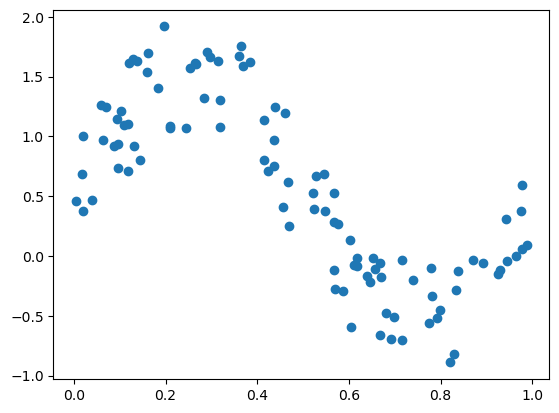

In [4]:
# データセットの可視化
plt.scatter(x, y)
plt.show()

### ニューラルネットワークの実装

In [5]:
# シグモイド関数の実装
def sigmoid_simple(x):
    x = as_variable(x)
    y = 1 / (1 + exp(-x))
    return y

- 一般的なニューラルネットワークは、「線形変換→活性化関数→線形変換→活性化関数→線形変換→…」という形で連続して変換を行う。

In [6]:
# 2層のニューラルネットワーク実装の流れの例

# W1, b1 = Variable(...), Variable(...)
# W2, b2 = Variable(...), Variable(...)

def predict(x):
    y = F.linear(x, W1, b1) # もしくはF.linear_simple(...)
    y = F.sigmoid(y) # もしくはF.sigmoid_simple(...)
    y = F.linear(y, W2, b2)
    return y

![picture 3](images/fb06ae7a21a50281a3766b46f3e93d953ab28ea5690f215db43d721e24a42359.png)  


In [7]:
# 2層のニューラルネット
import numpy as np
from dezero import Variable
import dezero.functions as F


# データセット
np.random.seed(3)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# ①重みの初期化
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H)) # 平均0、標準偏差1の正規分布の乱数
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O)) # 平均0、標準偏差1の正規分布の乱数
b2 = Variable(np.zeros(O))

# ②ニューラルネットの推論
def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

lr = 0.2
iters = 10000

# ③ニューラルネットワークの学習
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()
    

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data

    if i % 1000 == 0:
        print(loss)

variable(0.8722647600522339)
variable(0.2206454099239167)
variable(0.21865140900097102)
variable(0.21555997987741296)
variable(0.2086467963117385)
variable(0.1914762895568438)
variable(0.16153631060840962)
variable(0.11918660293845741)
variable(0.09373966143793573)
variable(0.09003987891653659)


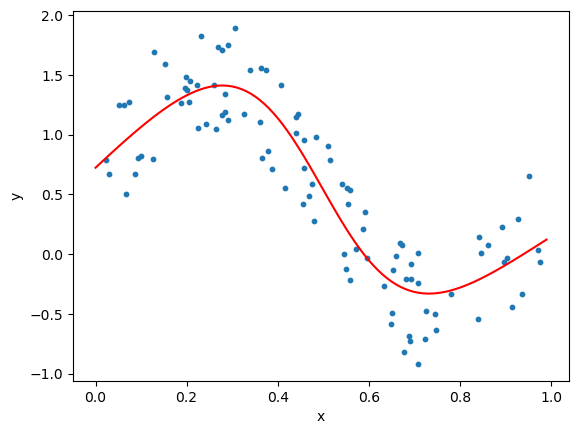

In [8]:
# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

この実装方法のままより深い層からなるニューラルネットワークを実装することも可能。  
ただし、層が増えるとパラメータの勾配をリセットしたりパラメータを更新したりする作業[③ニューラルネットワークを学習]が煩わしくなる。

### Step44: パラメータをまとめるレイヤ

パラメータの管理を自動化するためParameterとLayerという2つのクラスを実装する。

#### Parameterクラスの実装

In [9]:
class Parameter(Variable):
    pass

In [10]:
'''ParameterインスタンスとVariableインスタンスは全く同じ機能を持つが区別可能'''

import numpy as np
from dezero import Variable, Parameter

x = Variable(np.array(1.0))
p = Parameter(np.array(2.0))
y = x * p

print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
False
False


#### Layerクラスの実装
- パラメータを保持しパラメータを使った変換を行うクラス

In [11]:
class Layer:
    def __init__(self):
        self._params = set()
    
    def __setattr__(self, name, value): # 属性がインスタンスで代入される際に呼び出される
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value)

__setattr__はオブジェクトのあらゆるアクセスで呼び出されるために、super().__setattr__を使い、無限ループを回避する。  
参考サイト：「__getattr__, ___getattribute__, __setattr__について」　https://qiita.com/virusyun/items/db64737d1c60cdcbd25e

In [12]:
layer = Layer()

layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(3))
layer.p4 = 'test'

print(layer._params)
print('----------')

for name in layer._params:
    print(name, layer.__dict__[name]) # __dict__にはすべてのインスタンス変数が辞書形式で格納

{'p1', 'p2'}
----------
p1 variable(1)
p2 variable(2)


In [13]:
import weakref

class Layer:
    def __init__(self):
        self._params = set()
    
    def __setattr__(self, name, value): # 属性がインスタンスで代入される際に呼び出される
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value)
    
    # -----以下を追加-----

    def __call__(self, *inputs):
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs,)
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for y in outputs]
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, inputs):
        raise NotImplementedError()
    
    def params(self):
        for name in self._params:
            yield self.__dict__[name]
    
    def cleargrads(self):
        for param in self.params():
            param.cleargrad()

Layerクラスの役割
1. 属性代入時にパラメータの名前を保存
2. (__call__) forward実行（inputsとoutputsの保存）
3. パラメータをyieldする
3. 保存済のパラメータの勾配を削除

In [14]:
# yieldについて
def one_three():
    yield 1
    yield 2
    yield 3

generator = one_three()

print(next(generator))
print(next(generator))
print(next(generator))
# print(next(generator))


1
2
3


### Linearクラス（レイヤ）の実装

In [15]:
# Linearクラス（改良前）
import dezero.functions as F
from dezero.core import Parameter


class Linear(Layer):
    def __init__(self, in_size, out_size, nobias=False, dtype=np.float32):
        super().__init__()

        I, O = in_size, out_size
        W_data = np.random.randn(I, O).astype(dtype) * np.sqrt(1 / I) # LeCunの初期値
        self.W = Parameter(W_data, name='W')
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(0, dtype=dtype), name='b')
        
    def forward(self, x):
        y = F.linear(x, self.W, self.b)
        return y

![picture 2](../images/ac3d497f3db6ee48528ec2e9212683b288e3c073334a339dc419983d02345e34.png)  


In [16]:
# Linearクラス（改良後）
'''重みの生成をforwardメソッドの中で行うことでLinearクラスのin_sizeを自動で決めることができる'''

class Linear(Layer):
    def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.dtype = dtype
    
        self.W = Parameter(None, name='W')
        if self.in_size is not None: # in_size
            self._init_W()
        
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')
    
    def _init_W(self): # in_sizeが指定されている場合はそれに合わせて重みパラメータを作成
        I, O = self.in_size, self.out_size
        W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
        self.W.data = W_data
    
    def forward(self, x): # in_sizeが指定されていない場合はここで作成し、重みパラメータを作成後、線形変換
        if self.W.data is None:
            self.in_size = x.shape[1]
            self._init_W()
        
        y = F.linear(x, self.W, self.b)
        return y

#### Linearクラスを利用してsin関数のデータセットへの回帰を解く

In [17]:
import dezero.layers as L

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10)
l2 = L.Linear(1)

def predict(x):
    y = l1(x)
    y = F.sigmoid(y)
    y = l2(y)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    '''以下、パラメータごとでなくlayer単位でパラメータを処理できるようになった'''

    l1.cleargrads()
    l2.cleargrads()
    loss.backward()

    for l in [l1, l2]:
        for p in l.params():
            p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.0788816650635515)
variable(0.07655073683421636)
variable(0.07637803086238222)
variable(0.07618764131185568)


パラメータの管理をLinearインスタンスで行うことで、パラメータの勾配をリセットする処理やパラメータを更新する作業が前よりもすっきりした。
しかし、ここではLinearクラスを個別に扱っているため、ネットワークが深くなると大変。複数のLayerを1つのクラスにまとめて管理したい。

### Step45: レイヤをまとめるレイヤ

#### Layerクラスの拡張
- Layerクラスが別のLayerも保持できるように拡張する

![picture 1](images/abc2a60d3e78c67659cb02f3589e77e0df9436fd9c421c5c60691f0c45e2f82f.jpg)  


- 目標：一番上のLayerからその中にあるパラメータをすべて取り出せるようにすること

In [18]:
# Layerクラスの変更

class Layer:
    def __init__(self):
        self._params = set() # ParameterとLayerの両インスタンスの名前が保持される
    
    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)): # ①Layerも追加する
            self._params.add(name)
        super().__setattr__(name, value)
    
    def params(self):
        for name in self._params:
            obj = self.__dict__[name]

            if isinstance(obj, Layer): # ②Layerからパラメータを取り出す
                yield from obj.params()
            else:
                yield obj


- Layerクラスを継承して、1つのクラスとしてモデルを定義する方法

In [19]:
class TwoLayerNet(Layer):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
    
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

#### Modelクラスの作成

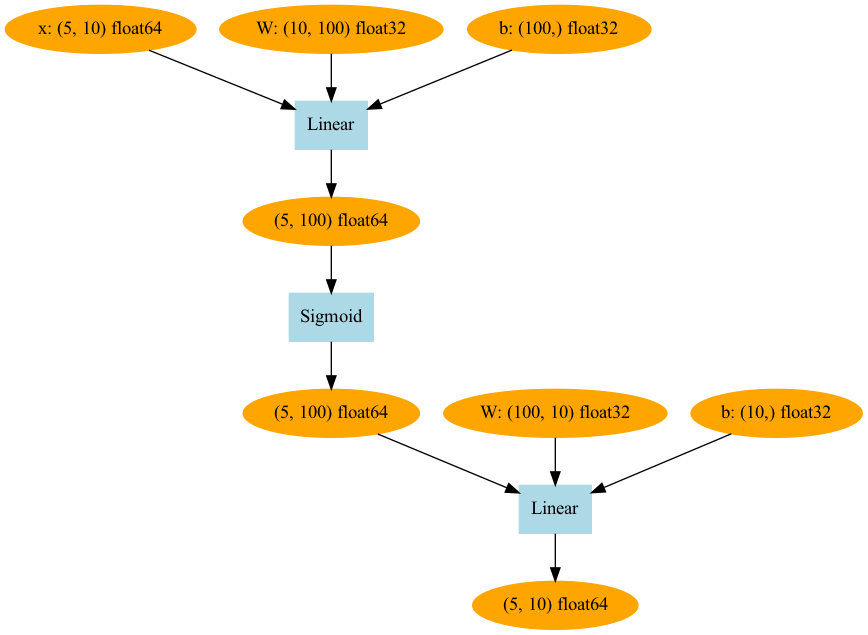

In [20]:
from dezero import Layer
from dezero import utils
from dezero import Variable, Model

class Model(Layer):
    def plot(self, *inputs, to_file='model.png'):
        y = self.forward(*inputs)
        return utils.plot_dot_graph(y, verbose=True, to_file=to_file)

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
    
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

#### Modelを使って問題を解く

In [21]:

# データセットの作成
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# ハイパーパラメータの設定
lr = 0.2
max_iter = 10000
hidden_size = 10

# モデルの定義
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
    
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

model = TwoLayerNet(hidden_size, 1)

# 学習の開始
for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    for p in model.params():
        p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.0788816650635515)
variable(0.07655073683421636)
variable(0.07637803086238222)
variable(0.07618764131185568)


こうして私たちはパラメータの管理から解放された。

### MLPクラス

より一般化した全結合層を実装したい

In [22]:
import dezero.functions as F

class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):
        super().__init__()
        self.activation = activation
        self.layers = []

        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer) # setattr(オブジェクト, 追加したい属性, 値)
            self.layers.append(layer)
        
    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)





In [23]:
model = MLP((10, 1)) # 2層
model = MLP((10, 20, 30, 40, 1)) #5層